In [130]:
import pandas as pd
import numpy as np

In [131]:
df = pd.read_csv('world_tourism_economy_data.csv')

In [132]:
df.shape

(6650, 11)

In [133]:
df.dtypes

country                     str
country_code                str
year                      int64
tourism_receipts        float64
tourism_arrivals        float64
tourism_exports         float64
tourism_departures      float64
tourism_expenditures    float64
gdp                     float64
inflation               float64
unemployment            float64
dtype: object

In [134]:
df.isna().sum()

country                    0
country_code               0
year                       0
tourism_receipts        2361
tourism_arrivals        1701
tourism_exports         2536
tourism_departures      4061
tourism_expenditures    2477
gdp                      226
inflation                982
unemployment            2992
dtype: int64

In [135]:
df.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,"782,000,000.00","972,000.00",62.54,NaN,9.50,"1,722,905,028.00",2.28,NaN
1,Africa Eastern and Southern,AFE,1999,"8,034,209,108.00","15,309,377.84",12.20,NaN,7.76,"265,429,000,000.00",7.82,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,"1,443,612,847.00","3,897,975.03",3.97,NaN,6.15,"139,468,000,000.00",0.37,NaN
4,Angola,AGO,1999,"31,000,000.00","45,000.00",0.58,NaN,2.49,"6,152,923,310.00",248.20,NaN


In [136]:
# Keep ISO3 code and focus on a stable pre-COVID period for segmentation
# (Using a multi-year average gives more stable clusters than a single year.)
df = df[df['country_code'].notna()].copy()
df['country_code'] = df['country_code'].astype(str).str.upper()

SEGMENT_START_YEAR = 2010
SEGMENT_END_YEAR = 2019

df_period = df[df['year'].between(SEGMENT_START_YEAR, SEGMENT_END_YEAR)].copy()
df_period[['country', 'country_code', 'year']].head()

,country,country_code,year
2926,Aruba,ABW,2010
2927,Africa Eastern and Southern,AFE,2010
2928,Afghanistan,AFG,2010
2929,Africa Western and Central,AFW,2010
2930,Angola,AGO,2010


In [137]:
numerical_cols = [
    'tourism_receipts',
    'tourism_arrivals',
    'tourism_exports',
    'tourism_departures',
    'tourism_expenditures',
    'gdp',
    'inflation',
    'unemployment',
]

In [138]:
# Fill missing values within each country time series
for col in numerical_cols:
    df_period[col] = df_period.groupby('country_code')[col].transform(lambda x: x.ffill().bfill())

In [139]:
# For any remaining NaN values (countries with sparse data), fill with the global median
for col in numerical_cols:
    df_period[col] = df_period[col].fillna(df_period[col].median())

In [140]:
# Feature Engineering (per country-year)
df_period['travel_balance'] = df_period['tourism_receipts'] - df_period['tourism_expenditures']
df_period['receipts_per_arrival'] = df_period['tourism_receipts'] / df_period['tourism_arrivals']

In [141]:
# Handle potential division by zero or NaN values in 'receipts_per_arrival'
df_period['receipts_per_arrival'] = df_period['receipts_per_arrival'].replace([np.inf, -np.inf], np.nan)
df_period['receipts_per_arrival'] = df_period['receipts_per_arrival'].fillna(0)

In [142]:
df.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,"782,000,000.00","972,000.00",62.54,NaN,9.50,"1,722,905,028.00",2.28,NaN
1,Africa Eastern and Southern,AFE,1999,"8,034,209,108.00","15,309,377.84",12.20,NaN,7.76,"265,429,000,000.00",7.82,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,"1,443,612,847.00","3,897,975.03",3.97,NaN,6.15,"139,468,000,000.00",0.37,NaN
4,Angola,AGO,1999,"31,000,000.00","45,000.00",0.58,NaN,2.49,"6,152,923,310.00",248.20,NaN


In [143]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               6650 non-null   str    
 1   country_code          6650 non-null   str    
 2   year                  6650 non-null   int64  
 3   tourism_receipts      4289 non-null   float64
 4   tourism_arrivals      4949 non-null   float64
 5   tourism_exports       4114 non-null   float64
 6   tourism_departures    2589 non-null   float64
 7   tourism_expenditures  4173 non-null   float64
 8   gdp                   6424 non-null   float64
 9   inflation             5668 non-null   float64
 10  unemployment          3658 non-null   float64
dtypes: float64(8), int64(1), str(2)
memory usage: 672.3 KB


In [144]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [145]:
# Aggregate to 1 row per country (mean over the chosen period)
feature_cols = numerical_cols + ['travel_balance', 'receipts_per_arrival']

df_country = (
    df_period
    .groupby(['country_code', 'country'], as_index=False)[feature_cols]
    .mean()
)

df_country.shape

(266, 12)

In [146]:
# Build the clustering matrix (numeric features only)
X = df_country[feature_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)

In [147]:
# Preprocess: impute + scale
preprocess = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

In [148]:
X_scaled = preprocess.fit_transform(X)

# Keep a DataFrame view for convenience (model uses the numeric matrix)
df_processed = pd.DataFrame(X_scaled, columns=feature_cols)
df_processed.insert(0, 'country', df_country['country'].values)
df_processed.insert(0, 'country_code', df_country['country_code'].values)

X_kmeans = df_processed[feature_cols].values

In [149]:
# Preview processed country-level features
df_processed.head()

,country_code,country,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,receipts_per_arrival
0,ABW,Aruba,-0.21,-0.29,2.73,-0.25,2.18,-0.29,-0.36,0.27,-0.21,-0.09
1,AFE,Africa Eastern and Southern,-0.04,-0.14,-0.31,-0.25,-0.45,-0.18,0.14,-0.26,-0.04,-0.14
2,AFG,Afghanistan,-0.22,-0.28,-0.53,-0.25,-1.28,-0.29,-0.04,-0.24,-0.22,-0.28
3,AFW,Africa Western and Central,-0.19,-0.25,-0.65,-0.25,0.66,-0.20,-0.24,-0.47,-0.19,-0.19
4,AGO,Angola,-0.22,-0.30,-0.75,-0.25,-1.31,-0.28,1.10,0.90,-0.22,0.13


In [150]:
print('Clustering period:', SEGMENT_START_YEAR, '-', SEGMENT_END_YEAR)
print('Countries:', df_country.shape[0])
print('Features used:', feature_cols)

Clustering period: 2010 - 2019
Countries: 266
Features used: ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_departures', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment', 'travel_balance', 'receipts_per_arrival']


In [151]:
# (Optional) Save the processed country-level feature table
out_path = f'world_tourism_country_features_{SEGMENT_START_YEAR}_{SEGMENT_END_YEAR}.csv'
df_processed.to_csv(out_path, index=False)
print('Saved:', out_path)

Saved: world_tourism_country_features_2010_2019.csv


In [152]:
# Use X_kmeans (scaled numeric matrix) for K-Means
X_kmeans.shape

(266, 10)

In [153]:
print('Country-level preprocessing is complete!')
print('Output file:', out_path)
print('First 5 rows:')
df_processed.head()

Country-level preprocessing is complete!
Output file: world_tourism_country_features_2010_2019.csv
First 5 rows:


,country_code,country,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,receipts_per_arrival
0,ABW,Aruba,-0.21,-0.29,2.73,-0.25,2.18,-0.29,-0.36,0.27,-0.21,-0.09
1,AFE,Africa Eastern and Southern,-0.04,-0.14,-0.31,-0.25,-0.45,-0.18,0.14,-0.26,-0.04,-0.14
2,AFG,Afghanistan,-0.22,-0.28,-0.53,-0.25,-1.28,-0.29,-0.04,-0.24,-0.22,-0.28
3,AFW,Africa Western and Central,-0.19,-0.25,-0.65,-0.25,0.66,-0.20,-0.24,-0.47,-0.19,-0.19
4,AGO,Angola,-0.22,-0.30,-0.75,-0.25,-1.31,-0.28,1.10,0.90,-0.22,0.13


In [154]:
df_processed.shape

(266, 12)

In [155]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # test K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_kmeans)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_kmeans, labels))

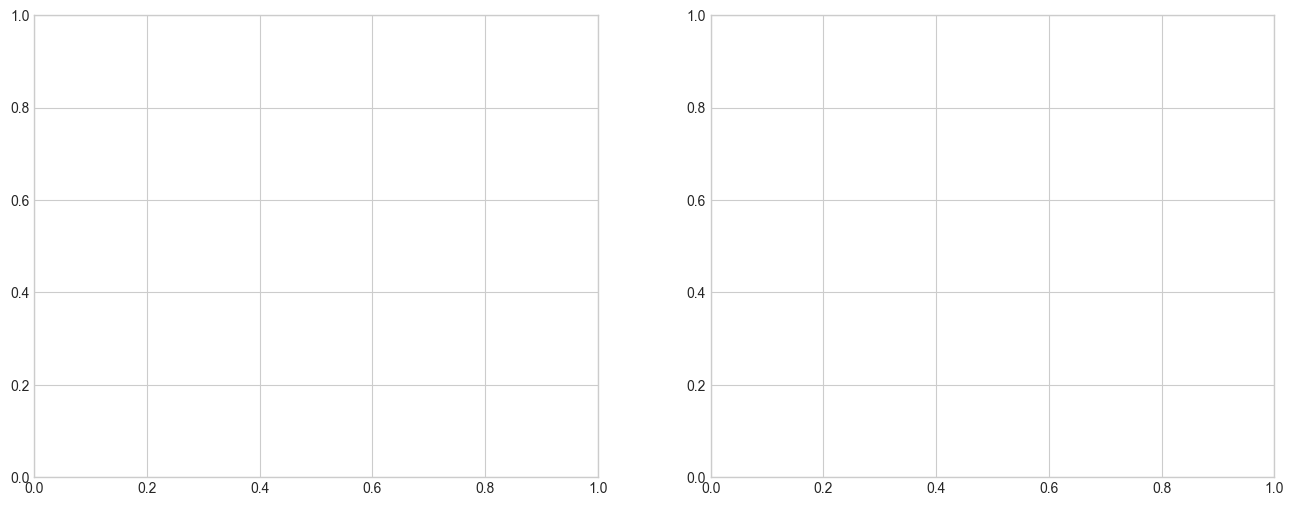

In [157]:
# --- Plotting the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

In [158]:
# Elbow Method Plot
ax1.plot(K_range, inertia, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal K')
ax2.grid(True)

plt.suptitle('Model Evaluation to Determine Optimal K', fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

In [159]:
from sklearn.decomposition import PCA

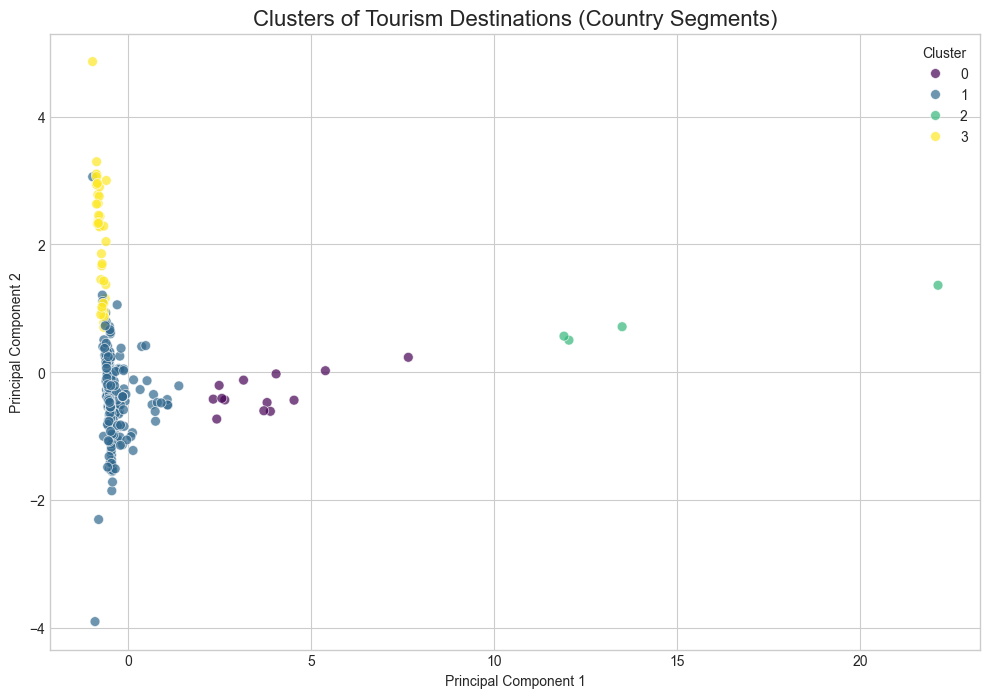

In [160]:
# --- Apply K-Means with the chosen K ---
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_kmeans)

# --- Use PCA for Dimensionality Reduction & Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans)

# Create a DataFrame with PCA results and cluster labels
visual_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
visual_df['Cluster'] = cluster_labels
visual_df['country_code'] = df_country['country_code'].values

# --- Plot the PCA scatter plot of clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=visual_df, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters of Tourism Destinations (Country Segments)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [161]:
# Attach cluster labels to the country-level table
clustered_countries = df_country.copy()
clustered_countries['Cluster'] = cluster_labels
clustered_countries.head()

,country_code,country,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,receipts_per_arrival,Cluster
0,ABW,Aruba,"1,657,000,000.00","1,705,100.00",65.90,"5,526,000.00",14.26,"2,893,631,899.70",1.15,9.07,"1,656,999,985.74",966.97,3
1,AFE,Africa Eastern and Southern,"25,835,221,885.00","35,587,408.55",9.89,"5,526,000.00",4.88,"941,120,100,000.00",6.24,6.31,"25,835,221,880.12",729.19,1
2,AFG,Afghanistan,"107,800,000.00","3,247,500.00",5.90,"5,526,000.00",1.93,"18,706,955,956.90",4.41,6.41,"107,799,998.07",33.19,1
3,AFW,Africa Western and Central,"5,514,448,439.60","11,673,943.31",3.52,"5,526,000.00",8.85,"750,928,800,000.00",2.37,5.17,"5,514,448,430.75",472.82,1
4,AGO,Angola,"856,300,000.00","436,500.00",1.83,"5,526,000.00",1.84,"95,924,531,778.50",16.09,12.41,"856,299,998.16","2,031.95",1


In [162]:
# Cluster interpretation: average profile per cluster
cluster_profiles = (
    clustered_countries
    .groupby('Cluster')[feature_cols]
    .mean()
    .sort_values(by='tourism_arrivals', ascending=False)
)

pd.options.display.float_format = '{:,.2f}'.format
print('Cluster Profiles (mean over period):')
cluster_profiles

Cluster Profiles (mean over period):


,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,receipts_per_arrival
Cluster,,,,,,,,,,
2,"1,053,954,600,000.00","1,425,701,314.57",6.35,"1,067,057,134.00",5.55,"56,858,370,000,000.00",1.89,6.59,"1,053,954,599,994.45",737.52
0,"146,056,189,235.54","560,223,013.95",7.32,"410,428,260.83",5.28,"20,474,292,000,000.00",2.72,6.21,"146,056,189,230.26",370.27
1,"10,495,336,678.30","21,631,699.29",9.26,"14,262,829.62",5.73,"700,861,115,221.13",5.44,7.50,"10,495,336,672.58","1,522.57"
3,"2,373,881,282.72","2,772,732.36",50.21,"4,306,248.57",10.77,"15,453,795,590.24",2.54,9.03,"2,373,881,271.94","1,107.84"


In [163]:
# Example countries per cluster
print('--- Example Destinations in Each Cluster ---')
for cluster_id in sorted(clustered_countries['Cluster'].unique()):
    countries = clustered_countries[clustered_countries['Cluster'] == cluster_id]['country'].unique()
    example_countries = list(countries)[:8]
    print(f"\nCluster {cluster_id}:")
    print(', '.join(example_countries))

--- Example Destinations in Each Cluster ---

Cluster 0:
Early-demographic dividend, East Asia & Pacific, Europe & Central Asia, Euro area, European Union, IBRD only, IDA & IBRD total, Low & middle income

Cluster 1:
Africa Eastern and Southern, Afghanistan, Africa Western and Central, Angola, Arab World, United Arab Emirates, Argentina, American Samoa

Cluster 2:
High income, OECD members, Post-demographic dividend, World

Cluster 3:
Aruba, Albania, Andorra, Armenia, Antigua and Barbuda, Bahamas, The, Bermuda, Barbados
